In [252]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Data import

In [253]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(train_df.head())

      Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27    3.0  115.027311         NaN           10.0      4   
1   3013          22    1.0   39.832524   23.169223            8.0      7   
2   8215           1    3.0   78.342215   47.671972           10.0      2   
3   2352           1    1.0   40.409907         NaN            1.0     10   
4  13866          94    2.0   64.285067   38.562517            9.0     16   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424         B         B        11      3097   
1         8.0       1966   0.118537         B         B        30      6207   
2        17.0       1988   0.025609         B         B        33      5261   
3        22.0       1977   0.007122         B         B         1       264   
4        16.0       1972   0.282798         B         B        33      8667   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2       




### Space optimization:

In [254]:
def reduce_mem_usage(df):
    """ 
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    """

    start_mem = df.memory_usage().sum() / 10242
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 10242
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [255]:
print(train_df.dtypes)

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object


In [256]:
train_df_optimized= reduce_mem_usage(train_df)

Memory usage of dataframe is 156.23 MB
Memory usage after optimization is: 49.84 MB
Decreased by 68.1%


In [257]:
print(train_df_optimized.dtypes)
train_df_optimized['HouseFloor'] = train_df_optimized['HouseFloor'].astype(dtype='int16')
train_df_optimized['Rooms'] = train_df_optimized['Rooms'].astype(dtype='int16')
train_df_optimized.info()

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  int16   
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32

## Start Analyzing

Exploratory Data Analysis

### Fixing NaNs:

In [258]:
train_df_optimized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  int16   
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  int16   
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [259]:
median_lifesquare = train_df_optimized['LifeSquare'].median()
train_df_optimized['LifeSquare'].fillna(median_lifesquare, inplace=True)

median_Healthcare_1 = train_df_optimized['Healthcare_1'].median()
train_df_optimized['Healthcare_1'].fillna(median_Healthcare_1, inplace=True)

In [260]:
train_df_optimized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  int16   
 3   Square         10000 non-null  float32 
 4   LifeSquare     10000 non-null  float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  int16   
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   10000 non-null  float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

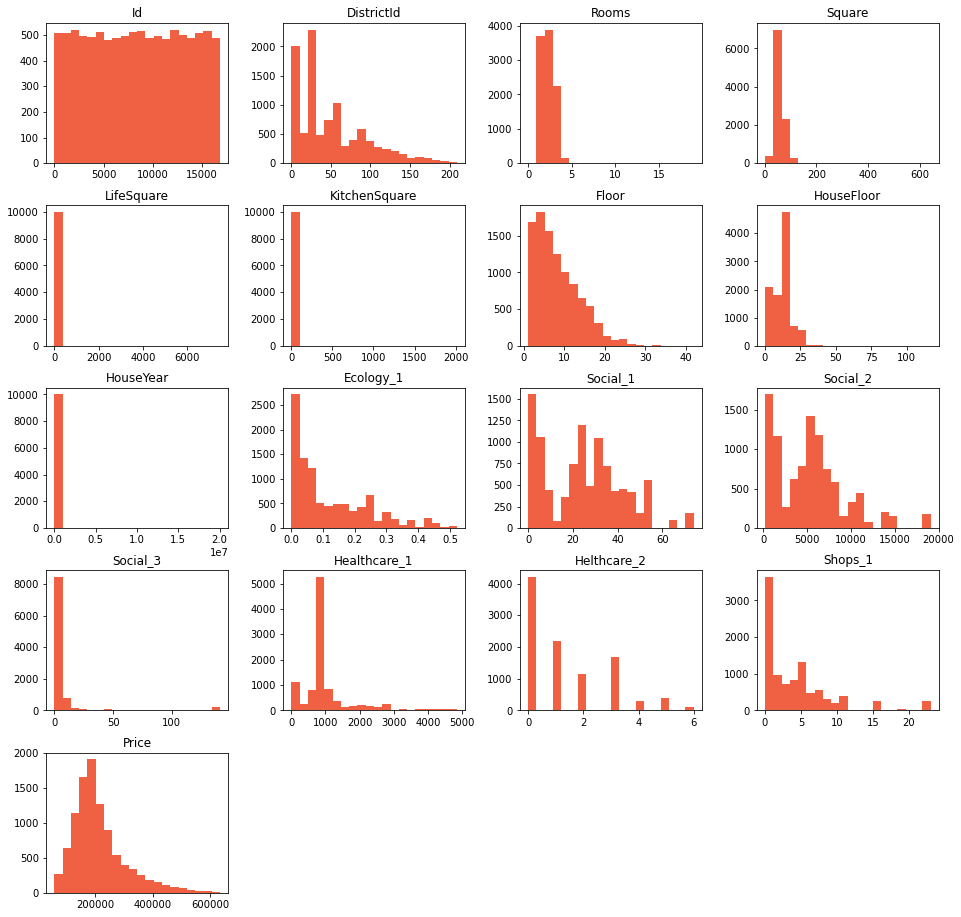

In [261]:
train_df_optimized.hist(figsize=(16,16), bins=20, grid=False);

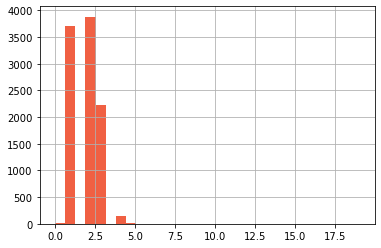

In [262]:
train_df_optimized['Rooms'].hist(bins=30)
plt.show()

##### I'll try to get rid of data with some anormous ammount of rooms later. 

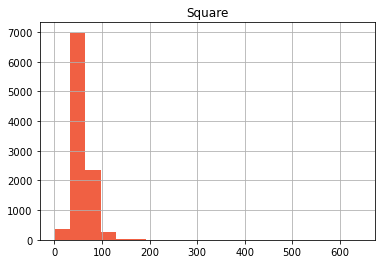

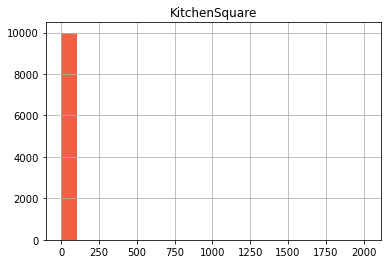

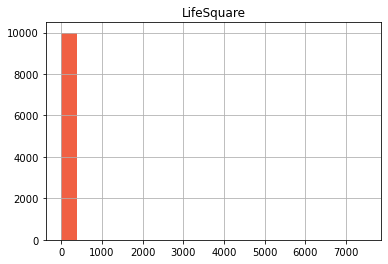

In [263]:
train_df_optimized['Square'].hist(bins=20)
plt.title('Square')
plt.show()

train_df_optimized['KitchenSquare'].hist(bins=20)
plt.title('KitchenSquare')
plt.show()

train_df_optimized['LifeSquare'].hist(bins=20)
plt.title('LifeSquare')
plt.show()

In [264]:
print(f'Square: \n{train_df_optimized["Square"].describe()} \n\n\n')
print(f'KitchenSquare: \n{train_df_optimized["KitchenSquare"].describe()} \n\n\n')
print(f'LifeSuqare: \n{train_df_optimized["LifeSquare"].describe()} \n\n\n')


Square: 
count    10000.000000
mean        56.315720
std         21.058716
min          1.136859
25%         41.774879
50%         52.513309
75%         65.900627
max        641.065186
Name: Square, dtype: float64 



KitchenSquare: 
count    10000.000000
mean         6.273300
std         28.560839
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64 



LifeSuqare: 
count    10000.000000
mean        36.266029
std         76.609962
min          0.370619
25%         25.527400
50%         32.781261
75%         41.427234
max       7480.592285
Name: LifeSquare, dtype: float64 





Notice, that KitchenSquare in some cases is bigger then Square and LifeSquare is bigger then Square.

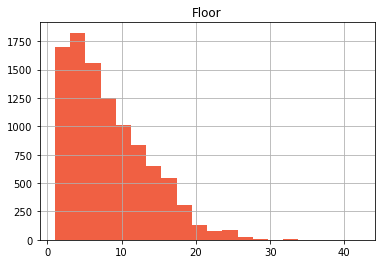

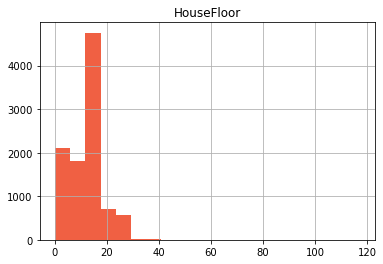

Floor: 
count    10000.000000
mean         8.526700
std          5.241148
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max         42.000000
Name: Floor, dtype: float64 



HouseFloor: 
count    10000.000000
mean        12.609400
std          6.775974
min          0.000000
25%          9.000000
50%         13.000000
75%         17.000000
max        117.000000
Name: HouseFloor, dtype: float64 





In [265]:
train_df_optimized['Floor'].hist(bins=20)
plt.title('Floor')
plt.show()

train_df_optimized['HouseFloor'].hist(bins=20)
plt.title('HouseFloor')
plt.show()

print(f'Floor: \n{train_df_optimized["Floor"].describe()} \n\n\n')
print(f'HouseFloor: \n{train_df_optimized["HouseFloor"].describe()} \n\n\n')

Changing everything I dislike to median)

In [266]:
train_df_optimized['LifeSquare'][train_df_optimized['LifeSquare'] >= train_df_optimized['LifeSquare'].quantile(0.96)] = train_df_optimized['LifeSquare'].median()
train_df_optimized.HouseYear[train_df_optimized.HouseYear >= datetime.now().year] = datetime.now().year
train_df_optimized['Square'][train_df_optimized['Square'] >= train_df_optimized['Square'].quantile(0.99)] = train_df_optimized['Square'].median()
train_df_optimized['KitchenSquare'][train_df_optimized['KitchenSquare'] >= train_df_optimized['KitchenSquare'].quantile(0.98)] = train_df_optimized['KitchenSquare'].median()
train_df_optimized['Rooms'][train_df_optimized['Rooms'] >= train_df_optimized['Rooms'].quantile(0.99)] = train_df_optimized['Rooms'].median()
train_df_optimized['HouseFloor'][train_df_optimized['HouseFloor'] >= train_df_optimized['HouseFloor'].quantile(0.97)] = train_df_optimized['HouseFloor'].median()
train_df_optimized['Floor'][train_df_optimized['Floor'] >= train_df_optimized['Floor'].quantile(0.97)] = train_df_optimized['Floor'].median()


<ipython-input-266-2acb57a15392>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_optimized['LifeSquare'][train_df_optimized['LifeSquare'] >= train_df_optimized['LifeSquare'].quantile(0.96)] = train_df_optimized['LifeSquare'].median()
<ipython-input-266-2acb57a15392>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_optimized.HouseYear[train_df_optimized.HouseYear >= datetime.now().year] = datetime.now().year
<ipython-input-266-2acb57a15392>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

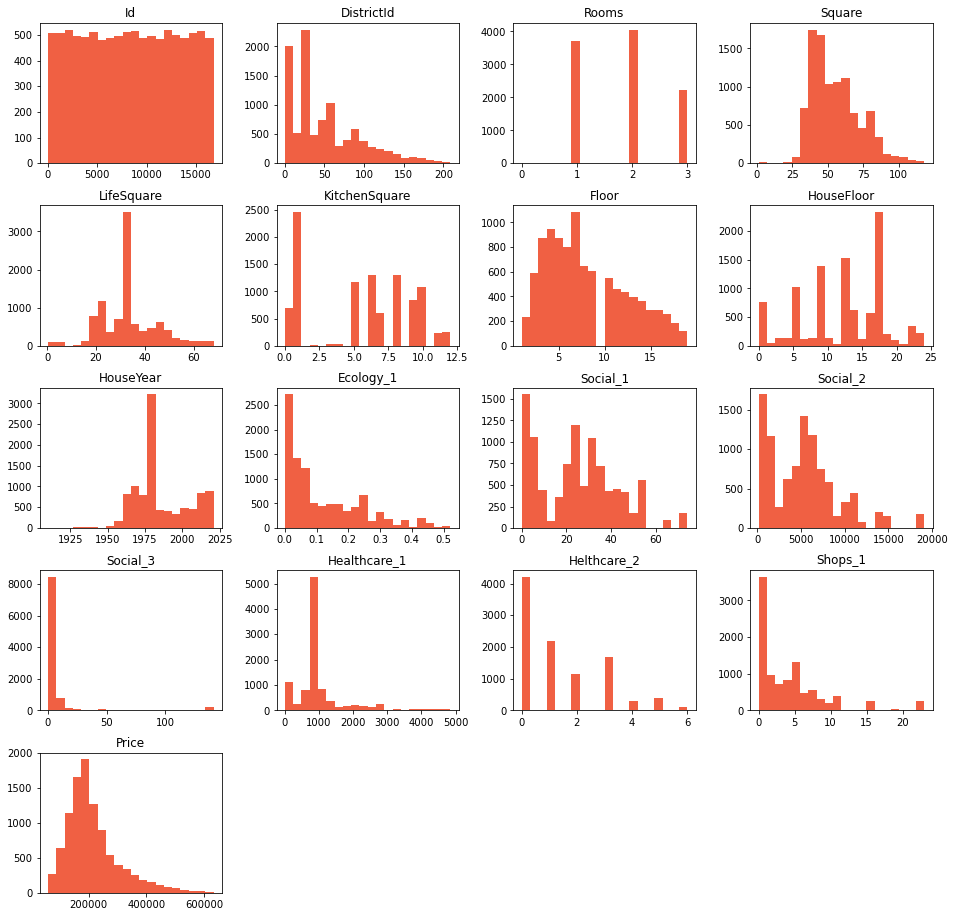

In [267]:
train_df_optimized.hist(figsize=(16,16), bins=20, grid=False);

In [268]:
drop_list=["Id", "Price", "Healthcare_1", "Ecology_2", "Shops_2", "Ecology_3"]

X = train_df_optimized.drop(drop_list, axis=1, inplace=False)
Y = train_df_optimized["Price"]
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.4, shuffle=True, random_state=42)

rf_model = RandomForestRegressor(n_estimators=400, max_depth=17, max_features= 10)
rf_model.fit(X_train, Y_train)

Y_train_preds = rf_model.predict(X_train)
Y_test_preds = rf_model.predict(X_valid)

print("R2 train:\t" + str(round(r2(Y_train, Y_train_preds), 3)))
print("R2 test:\t" + str(round(r2(Y_valid, Y_test_preds), 3)))

R2 train:	0.953
R2 test:	0.725


Searching for the best params:

In [269]:
parameters = {
    'n_estimators': [200,250,300,350,400,450],
    'max_features': np.arange(7, 12),
    'max_depth': np.arange(10, 17)
}

clf = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=parameters,
    scoring='r2',
    cv=5,
    n_jobs = 4
)

In [270]:
clf.fit(X_train, Y_train)
cv_results = pd.DataFrame(clf.cv_results_)
clf.best_params_

{'max_depth': 16, 'max_features': 7, 'n_estimators': 350}

In [272]:
rf_model_optimized = RandomForestRegressor(n_estimators=350, max_depth=16, max_features= 7)
rf_model_optimized.fit(X_train, Y_train)

Y_train_preds = rf_model_optimized.predict(X_train)
Y_test_preds = rf_model_optimized.predict(X_valid)

print("R2 train:\t" + str(round(r2(Y_train, Y_train_preds), 3)))
print("R2 test:\t" + str(round(r2(Y_valid, Y_test_preds), 3)))

R2 train:	0.947
R2 test:	0.723
